In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [7]:
from fastai.vision import *

# MNIST CNN

In [3]:
path = untar_data(URLs.MNIST)


In [4]:
path.ls()

[PosixPath('/Users/elvingomez/.fastai/data/mnist_png/training'),
 PosixPath('/Users/elvingomez/.fastai/data/mnist_png/testing')]

## DataBlock API exploded

In [9]:
imageList = ImageList.from_folder(path, convert_mode='L') #we need to pass L convert mode 'cause is not an rgb file'

In [10]:
imageList.items[0]

PosixPath('/Users/elvingomez/.fastai/data/mnist_png/training/9/36655.png')

In [11]:
defaults.cmap='binary'
#When we show images, normally it shows them in RGB. In this case, we want to use a binary color map

In [12]:
imageList

ImageList (70000 items)
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
Path: /Users/elvingomez/.fastai/data/mnist_png

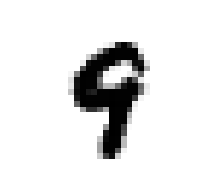

In [13]:
imageList[0].show()

In [14]:
splitData = imageList.split_by_folder(train='training', valid='testing')


Once you've got an image item list, you then split it into training versus validation. You nearly always want validation. If you don't, you can actually use the **.no_split** method to create an empty validation set. You can't skip it entirely. You have to say how to split, and one of the options is no_split.


In [15]:
splitData

ItemLists;

Train: ImageList (60000 items)
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
Path: /Users/elvingomez/.fastai/data/mnist_png;

Valid: ImageList (10000 items)
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
Path: /Users/elvingomez/.fastai/data/mnist_png;

Test: None

In [16]:
(path/'training').ls()

[PosixPath('/Users/elvingomez/.fastai/data/mnist_png/training/9'),
 PosixPath('/Users/elvingomez/.fastai/data/mnist_png/training/0'),
 PosixPath('/Users/elvingomez/.fastai/data/mnist_png/training/7'),
 PosixPath('/Users/elvingomez/.fastai/data/mnist_png/training/6'),
 PosixPath('/Users/elvingomez/.fastai/data/mnist_png/training/1'),
 PosixPath('/Users/elvingomez/.fastai/data/mnist_png/training/8'),
 PosixPath('/Users/elvingomez/.fastai/data/mnist_png/training/4'),
 PosixPath('/Users/elvingomez/.fastai/data/mnist_png/training/3'),
 PosixPath('/Users/elvingomez/.fastai/data/mnist_png/training/2'),
 PosixPath('/Users/elvingomez/.fastai/data/mnist_png/training/5')]

In [18]:
labelList = splitData.label_from_folder()
labelList

LabelLists;

Train: LabelList (60000 items)
x: ImageList
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
y: CategoryList
9,9,9,9,9
Path: /Users/elvingomez/.fastai/data/mnist_png;

Valid: LabelList (10000 items)
x: ImageList
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
y: CategoryList
9,9,9,9,9
Path: /Users/elvingomez/.fastai/data/mnist_png;

Test: None

In [20]:
x, y = labelList.train[0]

9 torch.Size([1, 28, 28])


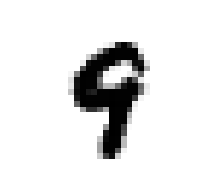

In [21]:
x.show()
print(y,x.shape)

In [22]:
tfms = ([*rand_pad(padding=3, size=28, mode='zeros')], []) # * is saying put both(padding & crop) transforms in this array

In [23]:
labelList = labelList.transform(tfms)
bs = 128

In [24]:
# not using imagenet_stats because not using pretrained model
data = labelList.databunch(bs=bs).normalize()

9


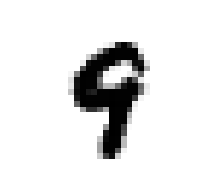

In [25]:
x.show()
print(y)

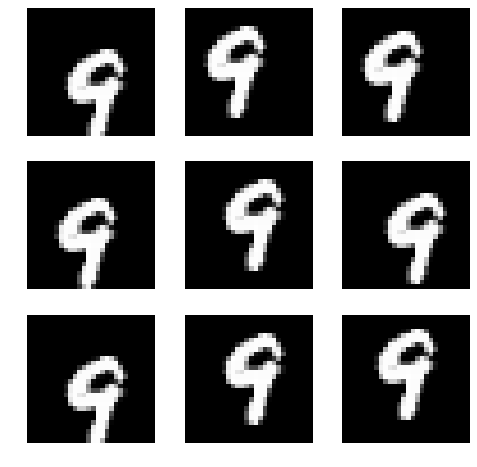

In [28]:
def _plot(i, j, ax):
    data.train_ds[0][0].show(ax, cmap='gray')
plot_multi(_plot, 3, 3, figsize=(8, 8)) #fastai function